In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = 3.0#2
std_dev = 3.0
total_samples = 8000#50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 20#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 5600
Validation set size: 1200
Test set size: 1200


In [3]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    # loss_2 = torch.sum(torch.log(det_jacobian + 1e-10))
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-alpha_nll*loss_2)/ dataset_length
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [4]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

In [5]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o",label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid

In [6]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [7]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [8]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [10]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [11]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0, plot_frequency=1):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.
    - print_model_params (int): Whether to print model parameters (0 or 1).
    - plot_frequency (int): Frequency of plotting histograms (e.g., every 5 epochs).

    Returns:
    None
    """
    # Filter epochs to plot based on frequency
    epochs_to_plot = [i for i in range(len(models_params)) if i % plot_frequency == 0 or i == 0]
    num_plots = len(epochs_to_plot)
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for plot_idx, epoch_idx in enumerate(epochs_to_plot):
        ax = axes[plot_idx]
        
        # Load model weights for the current epoch
        load_weights_into_model(model, models_params[epoch_idx])

        if print_model_params:
            #print(models_params[epoch_idx])
            print(f"slopes: constrrained coeffs: {model.slopes_tensor(for_projected_coeffs=1).detach()}")
        
        # Encode the test data
        with torch.no_grad():
            encoded_test1 = model(test_tensor)
        
        # Plot histogram on the subplot
        ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
        ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
        
        # Set title
        if epoch_idx == 0:
            ax.set_title("Before Training")
        else:
            ax.set_title(f"Epoch {epoch_idx}")  # Show actual epoch number
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.grid(True)
    
    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [12]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


initial nodal_val_locs: tensor([[-10.4015,  -9.4257,  -8.0974,  -7.9925,  -6.6648,  -6.5894,  -6.3217,
          -5.9700,  -4.7593,  -1.8697,  -0.2430,   0.1153,   1.1358,   3.9304,
           4.1511,   4.4250,   4.4543,   5.1796,   5.7553,   6.9382,   9.6432]])
initial fn values: Parameter containing:
tensor([-9.7180, -9.3373, -8.0449, -7.7511, -6.0329, -5.5531, -5.3577, -4.9501,
        -4.4339, -1.8382,  0.7564,  0.3973,  2.1584,  4.9921,  4.3936,  4.8977,
         4.5531,  6.0729,  6.7260,  7.0182, 10.4362], requires_grad=True)
constrained coefficients are:  tensor([-9.9798, -9.5991, -8.3067, -8.0129, -6.2946, -6.0686, -5.8731, -5.4656,
        -4.9493, -2.3536,  0.2410,  0.2445,  2.0056,  4.8393,  4.8415,  5.3456,
         5.3459,  6.8657,  7.5188,  7.8111, 11.2290], grad_fn=<ViewBackward0>)
slopes: constrained coeffs: tensor([[0.3901, 0.3901, 0.9730, 2.8002, 1.2941, 3.0000, 0.7300, 1.1587, 0.4264,
         0.8983, 1.5951, 0.0100, 1.7257, 1.0140, 0.0100, 1.8407, 0.0100, 2.0957,
  

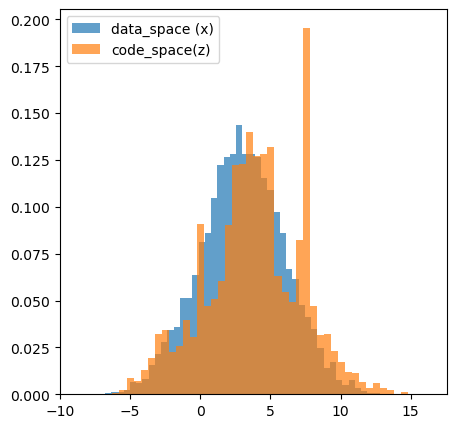

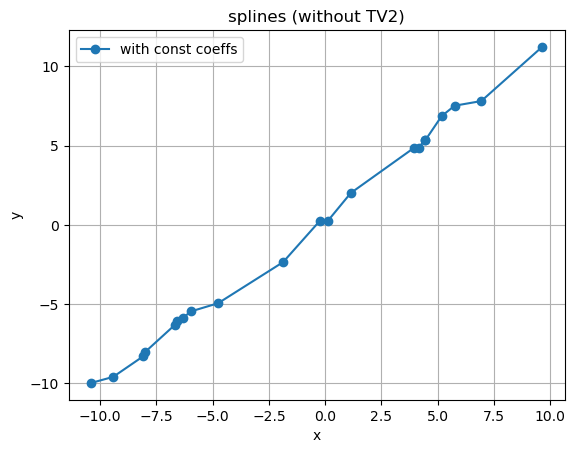

In [13]:
SIZE=21;RANGE=12; START_VAL=-6; END_VAL=11
GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                #grid_values=GRID_VALS,
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="random",#"maxmin",# what if I try relu activation function?
                smin=0.01,
                smax=3,
                slope_constrained=1
) # slopes of splines is 1, obviously

print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0)
plt.legend()
plt.show()

In [14]:
# training 100 rounds with low tv2 regularization
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.004,#0.004
    print_after=5,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.1,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0 . NOT ANYMORE

Training Progress:   5%|▌         | 5/100 [00:04<01:20,  1.18it/s]

Epoch 5/100,  train NLL+0.1XTV2: 5.827372418982642, data avg loss-1: 4.923358764818737 ,data avg loss-2: -0.1493661700174146 ,Training NLL Loss: 5.072724941798619, Validation NLL Loss: 4.656600934267044, LR: 0.004


Training Progress:  10%|█         | 10/100 [00:08<01:16,  1.18it/s]

Epoch 10/100,  train NLL+0.1XTV2: 4.7440027075154445, data avg loss-1: 3.7002014560358867 ,data avg loss-2: -0.27008759730129633 ,Training NLL Loss: 3.9702890498297556, Validation NLL Loss: 3.7567862550417583, LR: 0.004


Training Progress:  15%|█▌        | 15/100 [00:12<01:12,  1.18it/s]

Epoch 15/100,  train NLL+0.1XTV2: 4.148540908098221, data avg loss-1: 3.0514355054923468 ,data avg loss-2: -0.35790992874119965 ,Training NLL Loss: 3.4093454450368883, Validation NLL Loss: 3.2616684695084888, LR: 0.004


Training Progress:  20%|██        | 20/100 [00:16<01:06,  1.20it/s]

Epoch 20/100,  train NLL+0.1XTV2: 3.721986356803349, data avg loss-1: 2.623432433605194 ,data avg loss-2: -0.39450150430202485 ,Training NLL Loss: 3.0179339285407747, Validation NLL Loss: 2.8875944236914317, LR: 0.004


Training Progress:  25%|██▌       | 25/100 [00:21<01:03,  1.19it/s]

Epoch 25/100,  train NLL+0.1XTV2: 3.2712932710136684, data avg loss-1: 2.1787535831332208 ,data avg loss-2: -0.43767901839954515 ,Training NLL Loss: 2.6164326071739197, Validation NLL Loss: 2.4972199479738872, LR: 0.004


Training Progress:  30%|███       | 30/100 [00:25<00:58,  1.19it/s]

Epoch 30/100,  train NLL+0.1XTV2: 2.8930669673851557, data avg loss-1: 1.7612959282738823 ,data avg loss-2: -0.5131551639309951 ,Training NLL Loss: 2.274451095291546, Validation NLL Loss: 2.1716667771339417, LR: 0.004


Training Progress:  35%|███▌      | 35/100 [00:29<00:55,  1.18it/s]

Epoch 35/100,  train NLL+0.1XTV2: 2.593613200528281, data avg loss-1: 1.417720785524164 ,data avg loss-2: -0.6008067505700248 ,Training NLL Loss: 2.01852753502982, Validation NLL Loss: 1.927231059471766, LR: 0.004


Training Progress:  40%|████      | 40/100 [00:33<00:49,  1.20it/s]

Epoch 40/100,  train NLL+0.1XTV2: 2.453781517914363, data avg loss-1: 1.2254824524479253 ,data avg loss-2: -0.6675950303673744 ,Training NLL Loss: 1.8930774799415044, Validation NLL Loss: 1.827860995133718, LR: 0.004


Training Progress:  45%|████▌     | 45/100 [00:37<00:45,  1.21it/s]

Epoch 45/100,  train NLL+0.1XTV2: 2.411699865971293, data avg loss-1: 1.1592547680650438 ,data avg loss-2: -0.6913436683160918 ,Training NLL Loss: 1.850598430633545, Validation NLL Loss: 1.7874196410179137, LR: 0.004


Training Progress:  50%|█████     | 50/100 [00:41<00:40,  1.22it/s]

Epoch 50/100,  train NLL+0.1XTV2: 2.372962476525988, data avg loss-1: 1.0755657872983388 ,data avg loss-2: -0.7345016656177384 ,Training NLL Loss: 1.810067457812173, Validation NLL Loss: 1.7575870513916017, LR: 0.004


Training Progress:  55%|█████▌    | 55/100 [00:46<00:36,  1.23it/s]

Epoch 55/100,  train NLL+0.1XTV2: 2.335598957538605, data avg loss-1: 1.0226073911147457 ,data avg loss-2: -0.7518763963665281 ,Training NLL Loss: 1.774483790567943, Validation NLL Loss: 1.7273547212282816, LR: 0.004


Training Progress:  60%|██████    | 60/100 [00:50<00:32,  1.23it/s]

Epoch 60/100,  train NLL+0.1XTV2: 2.308860442042351, data avg loss-1: 0.9724760800600052 ,data avg loss-2: -0.7747581839561463 ,Training NLL Loss: 1.7472342716796057, Validation NLL Loss: 1.701552261908849, LR: 0.004


Training Progress:  65%|██████▌   | 65/100 [00:54<00:28,  1.22it/s]

Epoch 65/100,  train NLL+0.1XTV2: 2.2903783363955363, data avg loss-1: 0.9408683455416135 ,data avg loss-2: -0.7883215233683586 ,Training NLL Loss: 1.7291898701872144, Validation NLL Loss: 1.6887770136197409, LR: 0.004


Training Progress:  70%|███████   | 70/100 [00:58<00:24,  1.23it/s]

Epoch 70/100,  train NLL+0.1XTV2: 2.274610763362476, data avg loss-1: 0.9097583119358336 ,data avg loss-2: -0.8032689486231123 ,Training NLL Loss: 1.7130272660936627, Validation NLL Loss: 1.6767488876978556, LR: 0.004


Training Progress:  75%|███████▌  | 75/100 [01:02<00:20,  1.23it/s]

Epoch 75/100,  train NLL+0.1XTV2: 2.2576653489044736, data avg loss-1: 0.8701324374548026 ,data avg loss-2: -0.8261589654854365 ,Training NLL Loss: 1.6962914019823074, Validation NLL Loss: 1.6617052773634593, LR: 0.004


Training Progress:  80%|████████  | 80/100 [01:06<00:16,  1.18it/s]

Epoch 80/100,  train NLL+0.1XTV2: 2.239539978333882, data avg loss-1: 0.8221056195242065 ,data avg loss-2: -0.8537469612700599 ,Training NLL Loss: 1.6758525788784027, Validation NLL Loss: 1.6460358421007792, LR: 0.004


Training Progress:  85%|████████▌ | 85/100 [01:10<00:12,  1.19it/s]

Epoch 85/100,  train NLL+0.1XTV2: 2.2210028593029296, data avg loss-1: 0.766096367686987 ,data avg loss-2: -0.8904545288000788 ,Training NLL Loss: 1.6565508965935025, Validation NLL Loss: 1.6291617413361867, LR: 0.004


Training Progress:  90%|█████████ | 90/100 [01:15<00:08,  1.22it/s]

Epoch 90/100,  train NLL+0.1XTV2: 2.2026497687612263, data avg loss-1: 0.7009378761851361 ,data avg loss-2: -0.9359427833131382 ,Training NLL Loss: 1.63688066474029, Validation NLL Loss: 1.615641438961029, LR: 0.004


Training Progress:  95%|█████████▌| 95/100 [01:19<00:04,  1.23it/s]

Epoch 95/100,  train NLL+0.1XTV2: 2.211256112371172, data avg loss-1: 0.6978649979191167 ,data avg loss-2: -0.9461900777050427 ,Training NLL Loss: 1.644055079136576, Validation NLL Loss: 1.617498767375946, LR: 0.002


Training Progress: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]

Epoch 100/100,  train NLL+0.1XTV2: 2.187299938712801, data avg loss-1: 0.6491433089332921 ,data avg loss-2: -0.9727802781122071 ,Training NLL Loss: 1.621923586300441, Validation NLL Loss: 1.6045828421910604, LR: 0.002
Training complete


In [15]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0, plot_freq=5
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                            ],

                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    plt.axhline(y=-mean/std_dev)
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y")
    plt.legend()
    plt.show()
    ## 
    print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    #plot_coefficients_evolution(num_coeffs,
    #                            np.array(coeffs_unconstrained_evol2), 
    #                            np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) # slopes of splines is 1, obviously
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params, plot_frequency=plot_freq)


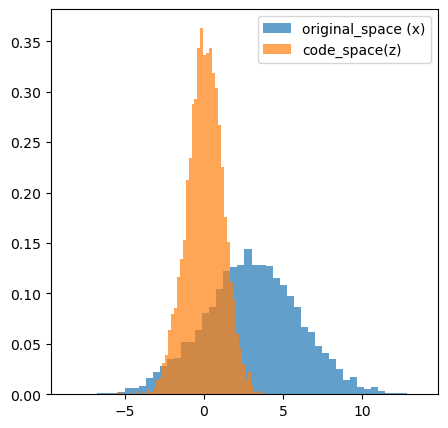

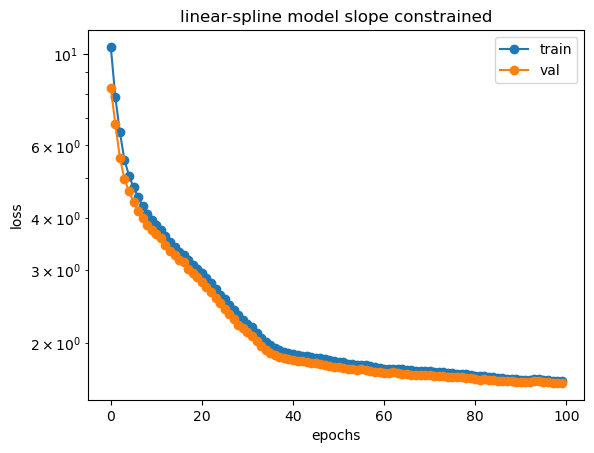

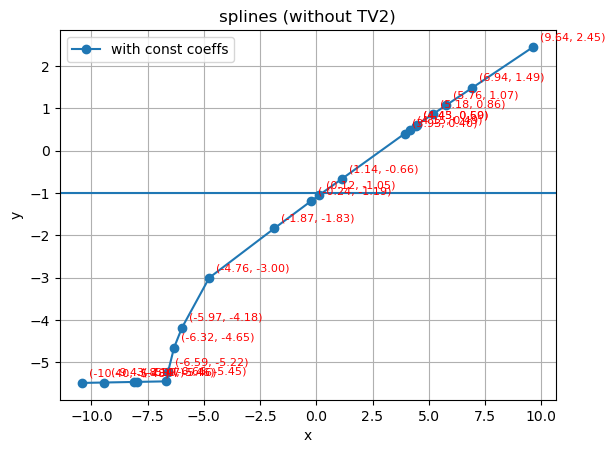

slopes: constrained coeffs: tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 3.0000, 2.1397, 1.3357, 0.9723,
         0.4034, 0.3946, 0.3908, 0.3801, 0.3826, 0.3795, 0.3803, 0.3810, 0.3571,
         0.3586, 0.3544, 0.3561]], grad_fn=<ClampBackward1>)
initial nodal_val_locs: tensor([[-10.4015,  -9.4257,  -8.0974,  -7.9925,  -6.6648,  -6.5894,  -6.3217,
          -5.9700,  -4.7593,  -1.8697,  -0.2430,   0.1153,   1.1358,   3.9304,
           4.1511,   4.4250,   4.4543,   5.1796,   5.7553,   6.9382,   9.6432]])
initial fn values: Parameter containing:
tensor([10.4015,  9.4257,  8.0974,  7.9925,  6.6648,  6.5894,  6.3217,  5.9700,
         4.7593,  1.8697,  0.2430,  0.1153,  1.1358,  3.9304,  4.1511,  4.4250,
         4.4543,  5.1796,  5.7553,  6.9382,  9.6432], requires_grad=True)


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


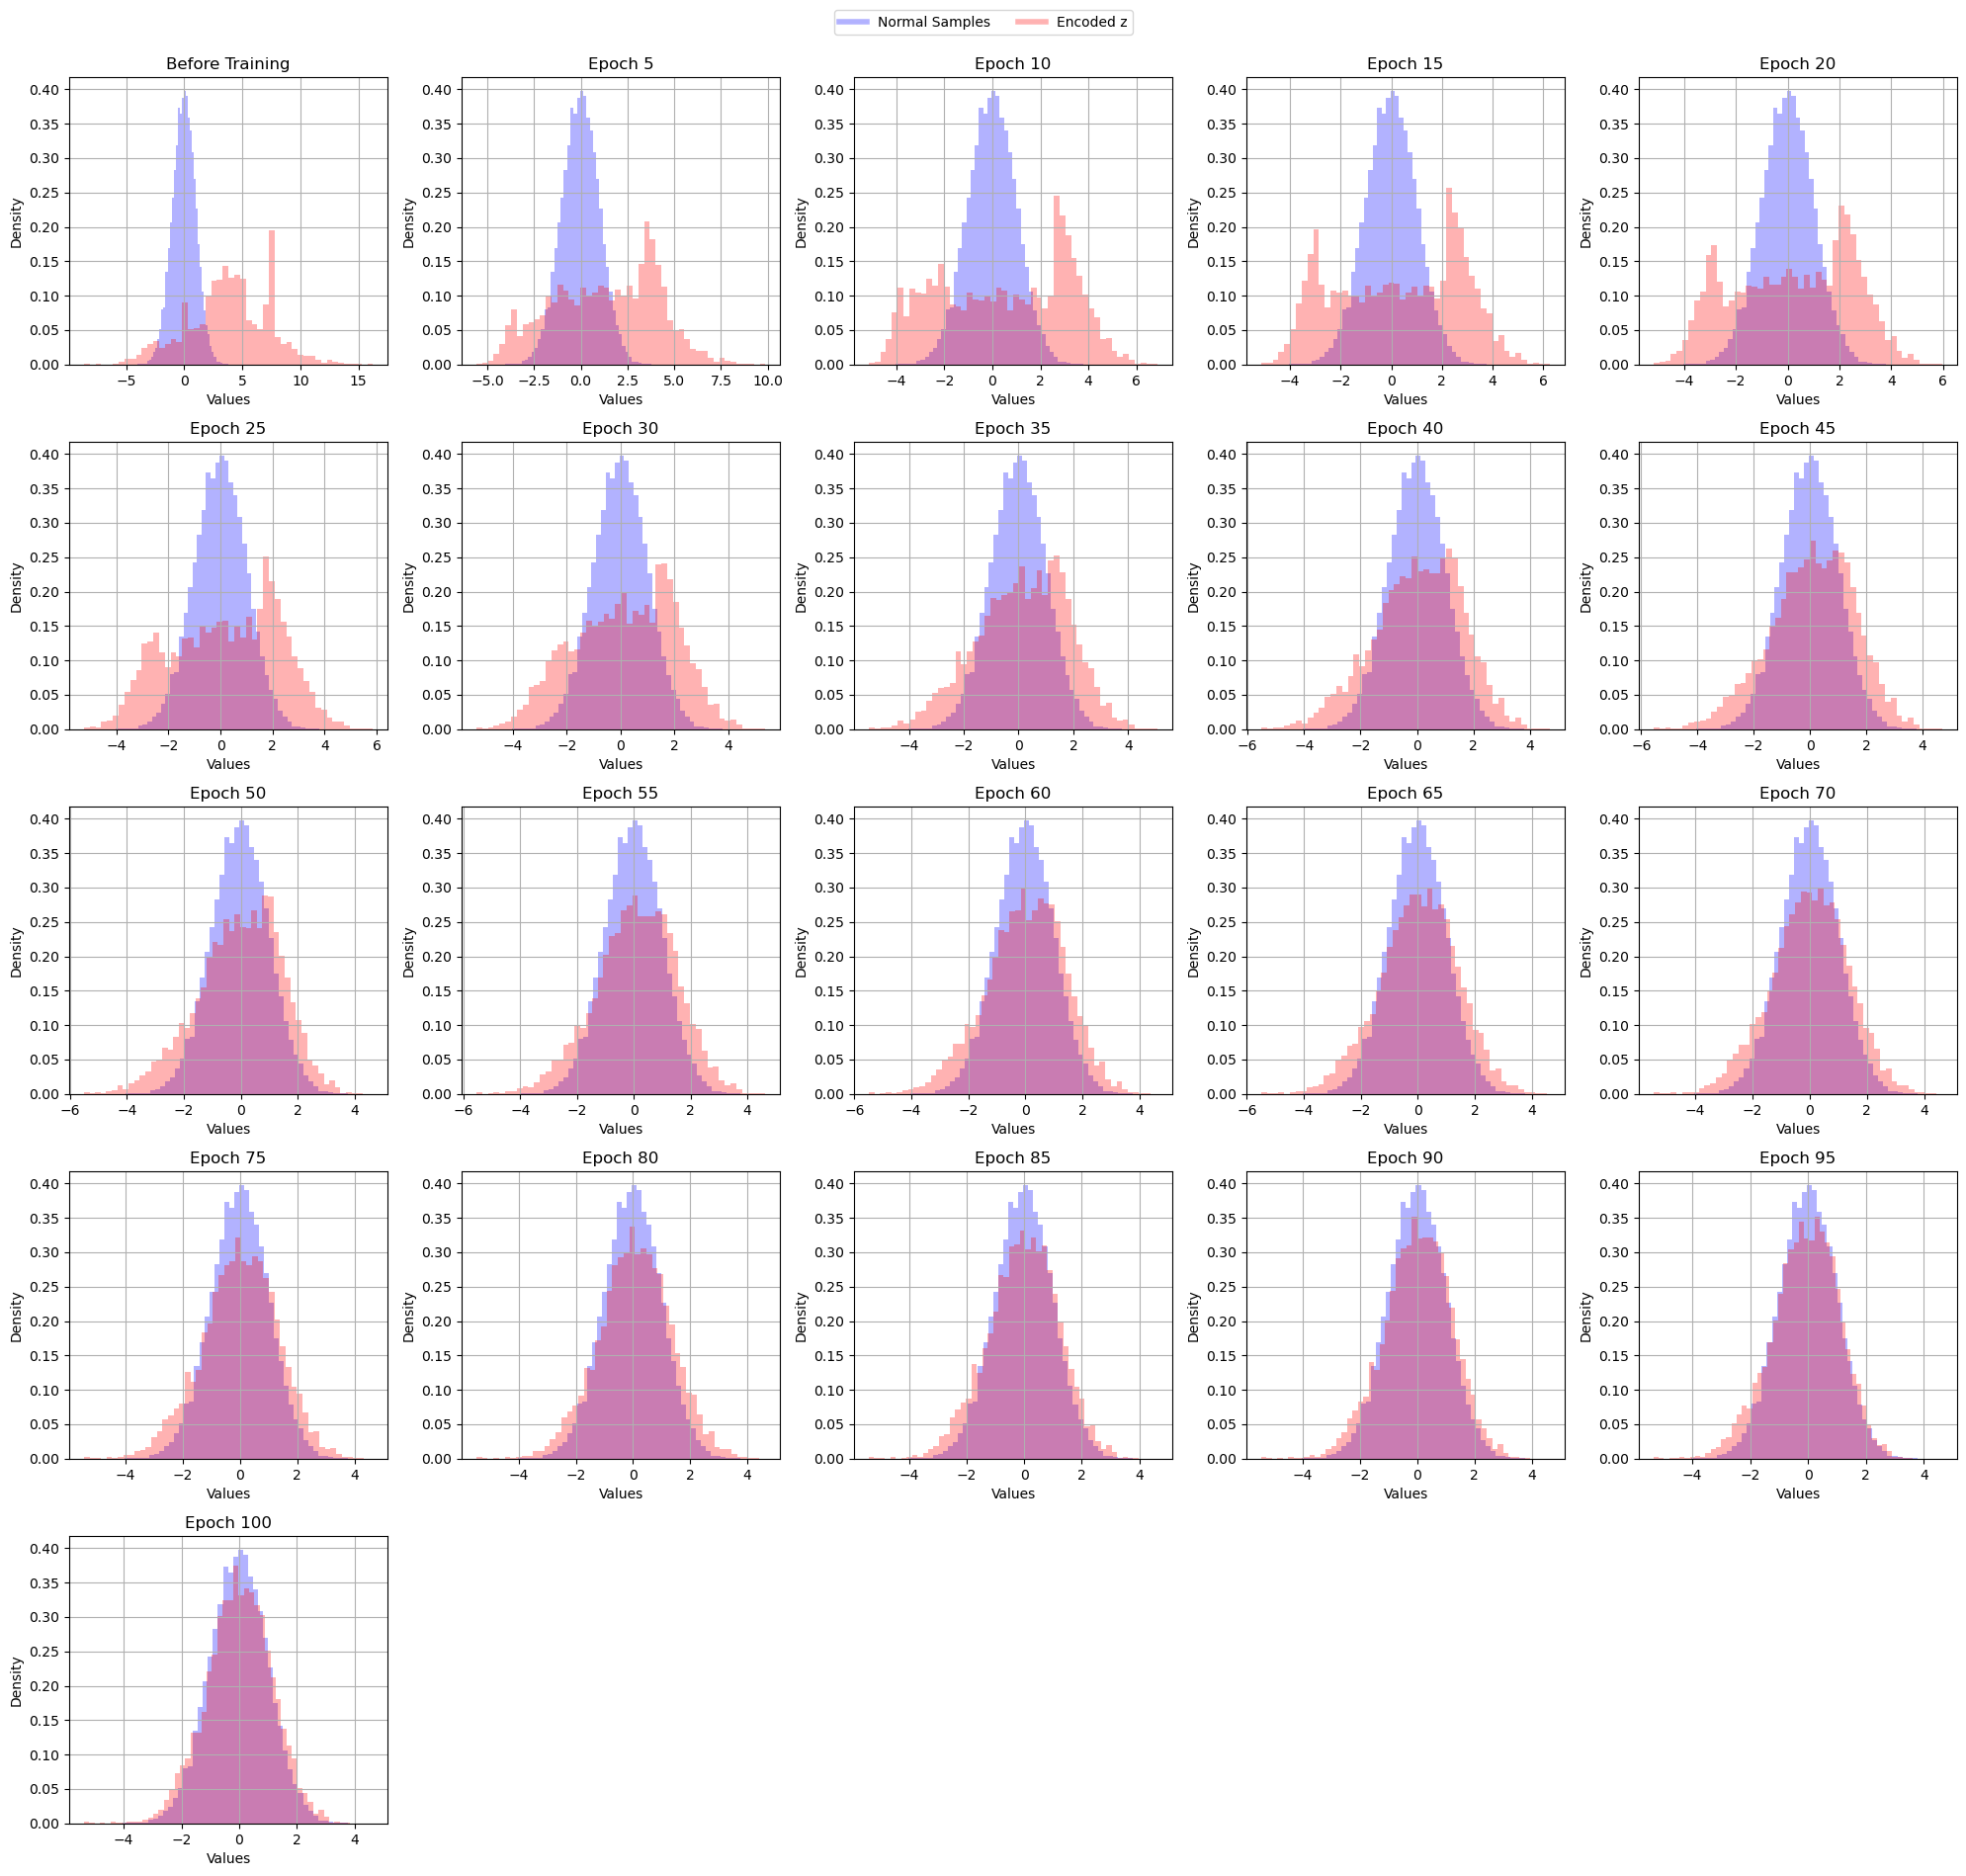

In [16]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=5) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)

In [18]:
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
   model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.004,#0.004
    print_after=5,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.1,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1
) 

Training Progress:   5%|▌         | 5/100 [00:04<01:20,  1.18it/s]

Epoch 5/100,  train NLL+0.1XTV2: 2.179904732108116, data avg loss-1: 0.5757390107959509 ,data avg loss-2: -1.0350071709070887 ,Training NLL Loss: 1.6107461822884424, Validation NLL Loss: 1.5982880175113678, LR: 0.004


Training Progress:  10%|█         | 10/100 [00:08<01:17,  1.17it/s]

Epoch 10/100,  train NLL+0.1XTV2: 2.178513697215489, data avg loss-1: 0.5354306415787765 ,data avg loss-2: -1.0709079546587807 ,Training NLL Loss: 1.6063385963439942, Validation NLL Loss: 1.5977075219154357, LR: 0.004


Training Progress:  15%|█▌        | 15/100 [00:12<01:12,  1.17it/s]

Epoch 15/100,  train NLL+0.1XTV2: 2.1735260541949954, data avg loss-1: 0.5237071879208088 ,data avg loss-2: -1.0814320012927054 ,Training NLL Loss: 1.6051391861268451, Validation NLL Loss: 1.5975457648436229, LR: 0.002


Training Progress:  20%|██        | 20/100 [00:17<01:09,  1.16it/s]

Epoch 20/100,  train NLL+0.1XTV2: 2.173125037550926, data avg loss-1: 0.5111744214381491 ,data avg loss-2: -1.09322409927845 ,Training NLL Loss: 1.6043985226324626, Validation NLL Loss: 1.5984936594963073, LR: 0.001


Training Progress:  25%|██▌       | 25/100 [00:21<01:05,  1.15it/s]

Epoch 25/100,  train NLL+0.1XTV2: 2.1714498792375836, data avg loss-1: 0.5102806516523872 ,data avg loss-2: -1.0936430805495807 ,Training NLL Loss: 1.603923738854272, Validation NLL Loss: 1.5973673939704895, LR: 0.001


Training Progress:  30%|███       | 30/100 [00:25<00:59,  1.18it/s]

Epoch 30/100,  train NLL+0.1XTV2: 2.170342000041689, data avg loss-1: 0.5055887739041022 ,data avg loss-2: -1.097962446297918 ,Training NLL Loss: 1.6035512234483447, Validation NLL Loss: 1.5978044549624124, LR: 0.0005


Training Progress:  35%|███▌      | 35/100 [00:30<00:55,  1.17it/s]

Epoch 35/100,  train NLL+0.1XTV2: 2.170003173180989, data avg loss-1: 0.5033998734716858 ,data avg loss-2: -1.100046022449221 ,Training NLL Loss: 1.6034458986350468, Validation NLL Loss: 1.5978437185287475, LR: 0.000125


Training Progress:  40%|████      | 40/100 [00:34<00:50,  1.19it/s]

Epoch 40/100,  train NLL+0.1XTV2: 2.1695872391973223, data avg loss-1: 0.5028906068099397 ,data avg loss-2: -1.1004156036036354 ,Training NLL Loss: 1.6033062130212783, Validation NLL Loss: 1.5980629086494447, LR: 6.25e-05


Training Progress:  45%|████▌     | 45/100 [00:38<00:46,  1.18it/s]

Epoch 45/100,  train NLL+0.1XTV2: 2.169492322206497, data avg loss-1: 0.5030046993600471 ,data avg loss-2: -1.100272281893662 ,Training NLL Loss: 1.603276977794511, Validation NLL Loss: 1.5980130811532338, LR: 1.5625e-05


Training Progress:  50%|█████     | 50/100 [00:42<00:41,  1.22it/s]

Epoch 50/100,  train NLL+0.1XTV2: 2.169430278454508, data avg loss-1: 0.5029294842055866 ,data avg loss-2: -1.1003188793148313 ,Training NLL Loss: 1.6032483590500695, Validation NLL Loss: 1.5980215350786844, LR: 7.8125e-06


Training Progress:  55%|█████▌    | 55/100 [00:46<00:36,  1.23it/s]

Epoch 55/100,  train NLL+0.1XTV2: 2.169407621026039, data avg loss-1: 0.5029108003314052 ,data avg loss-2: -1.1003259296928134 ,Training NLL Loss: 1.6032367327383585, Validation NLL Loss: 1.5980229516824087, LR: 1.953125e-06


Training Progress:  60%|██████    | 60/100 [00:50<00:33,  1.19it/s]

Epoch 60/100,  train NLL+0.1XTV2: 2.1694003079618724, data avg loss-1: 0.5029107978301389 ,data avg loss-2: -1.100322453890528 ,Training NLL Loss: 1.6032332505498614, Validation NLL Loss: 1.5980220139026642, LR: 4.8828125e-07


Training Progress:  65%|██████▌   | 65/100 [00:55<00:29,  1.18it/s]

Epoch 65/100,  train NLL+0.1XTV2: 2.169399695737021, data avg loss-1: 0.5028973734804563 ,data avg loss-2: -1.1003363966941833 ,Training NLL Loss: 1.6032337712390081, Validation NLL Loss: 1.5980235894521078, LR: 2.44140625e-07


Training Progress:  70%|███████   | 70/100 [00:59<00:24,  1.20it/s]

Epoch 70/100,  train NLL+0.1XTV2: 2.1693995339529857, data avg loss-1: 0.5028934084411179 ,data avg loss-2: -1.1003401928714343 ,Training NLL Loss: 1.6032336077519826, Validation NLL Loss: 1.598024074236552, LR: 6.103515625e-08


Training Progress:  75%|███████▌  | 75/100 [01:03<00:21,  1.16it/s]

Epoch 75/100,  train NLL+0.1XTV2: 2.1693994505064826, data avg loss-1: 0.5028930136667831 ,data avg loss-2: -1.1003405619944846 ,Training NLL Loss: 1.6032335715634483, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08


Training Progress:  80%|████████  | 80/100 [01:07<00:16,  1.18it/s]

Epoch 80/100,  train NLL+0.1XTV2: 2.1693994641304015, data avg loss-1: 0.5028930192015001 ,data avg loss-2: -1.1003405660390855 ,Training NLL Loss: 1.6032335851873671, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08


Training Progress:  85%|████████▌ | 85/100 [01:12<00:12,  1.17it/s]

Epoch 85/100,  train NLL+0.1XTV2: 2.169399458169937, data avg loss-1: 0.5028930186693158 ,data avg loss-2: -1.100340562420232 ,Training NLL Loss: 1.6032335813556398, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08


Training Progress:  90%|█████████ | 90/100 [01:16<00:08,  1.18it/s]

Epoch 90/100,  train NLL+0.1XTV2: 2.169399460724422, data avg loss-1: 0.502893019680466 ,data avg loss-2: -1.1003405588013786 ,Training NLL Loss: 1.6032335847616195, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08


Training Progress:  95%|█████████▌| 95/100 [01:20<00:04,  1.19it/s]

Epoch 95/100,  train NLL+0.1XTV2: 2.1693994658333913, data avg loss-1: 0.502893022022077 ,data avg loss-2: -1.1003405698708126 ,Training NLL Loss: 1.6032335894448417, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08


Training Progress: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

Epoch 100/100,  train NLL+0.1XTV2: 2.169399456466947, data avg loss-1: 0.5028930210109268 ,data avg loss-2: -1.1003405605043683 ,Training NLL Loss: 1.6032335800783974, Validation NLL Loss: 1.5980241497357686, LR: 1.52587890625e-08
Training complete


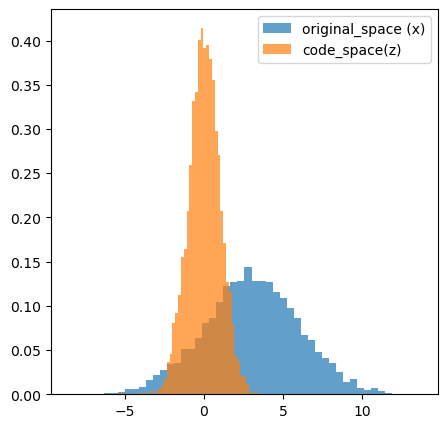

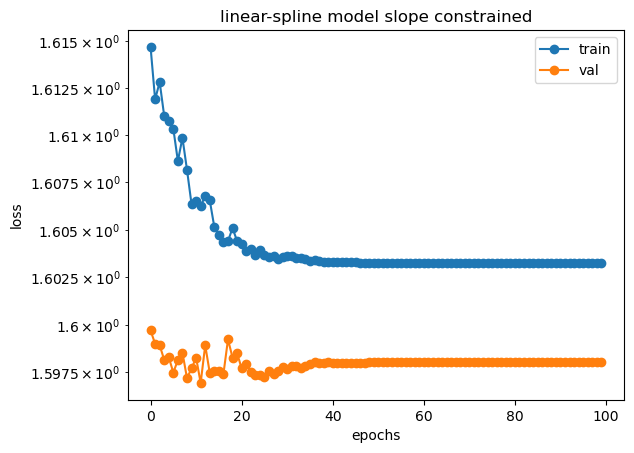

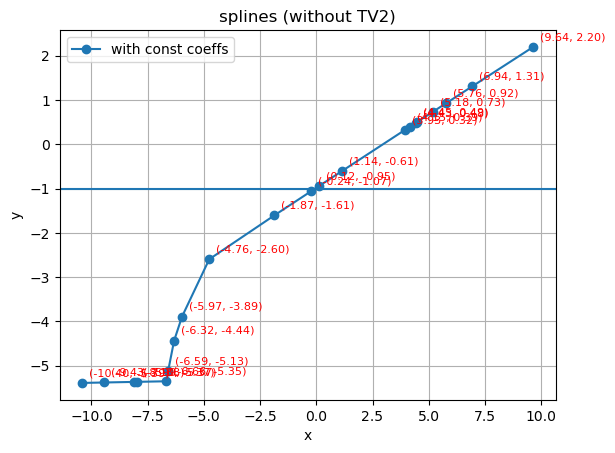

slopes: constrained coeffs: tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 3.0000, 2.5774, 1.5425, 1.0711,
         0.3422, 0.3338, 0.3320, 0.3319, 0.3319, 0.3318, 0.3311, 0.3287, 0.3283,
         0.3283, 0.3283, 0.3283]], grad_fn=<ClampBackward1>)
initial nodal_val_locs: tensor([[-10.4015,  -9.4257,  -8.0974,  -7.9925,  -6.6648,  -6.5894,  -6.3217,
          -5.9700,  -4.7593,  -1.8697,  -0.2430,   0.1153,   1.1358,   3.9304,
           4.1511,   4.4250,   4.4543,   5.1796,   5.7553,   6.9382,   9.6432]])
initial fn values: Parameter containing:
tensor([10.4015,  9.4257,  8.0974,  7.9925,  6.6648,  6.5894,  6.3217,  5.9700,
         4.7593,  1.8697,  0.2430,  0.1153,  1.1358,  3.9304,  4.1511,  4.4250,
         4.4543,  5.1796,  5.7553,  6.9382,  9.6432], requires_grad=True)


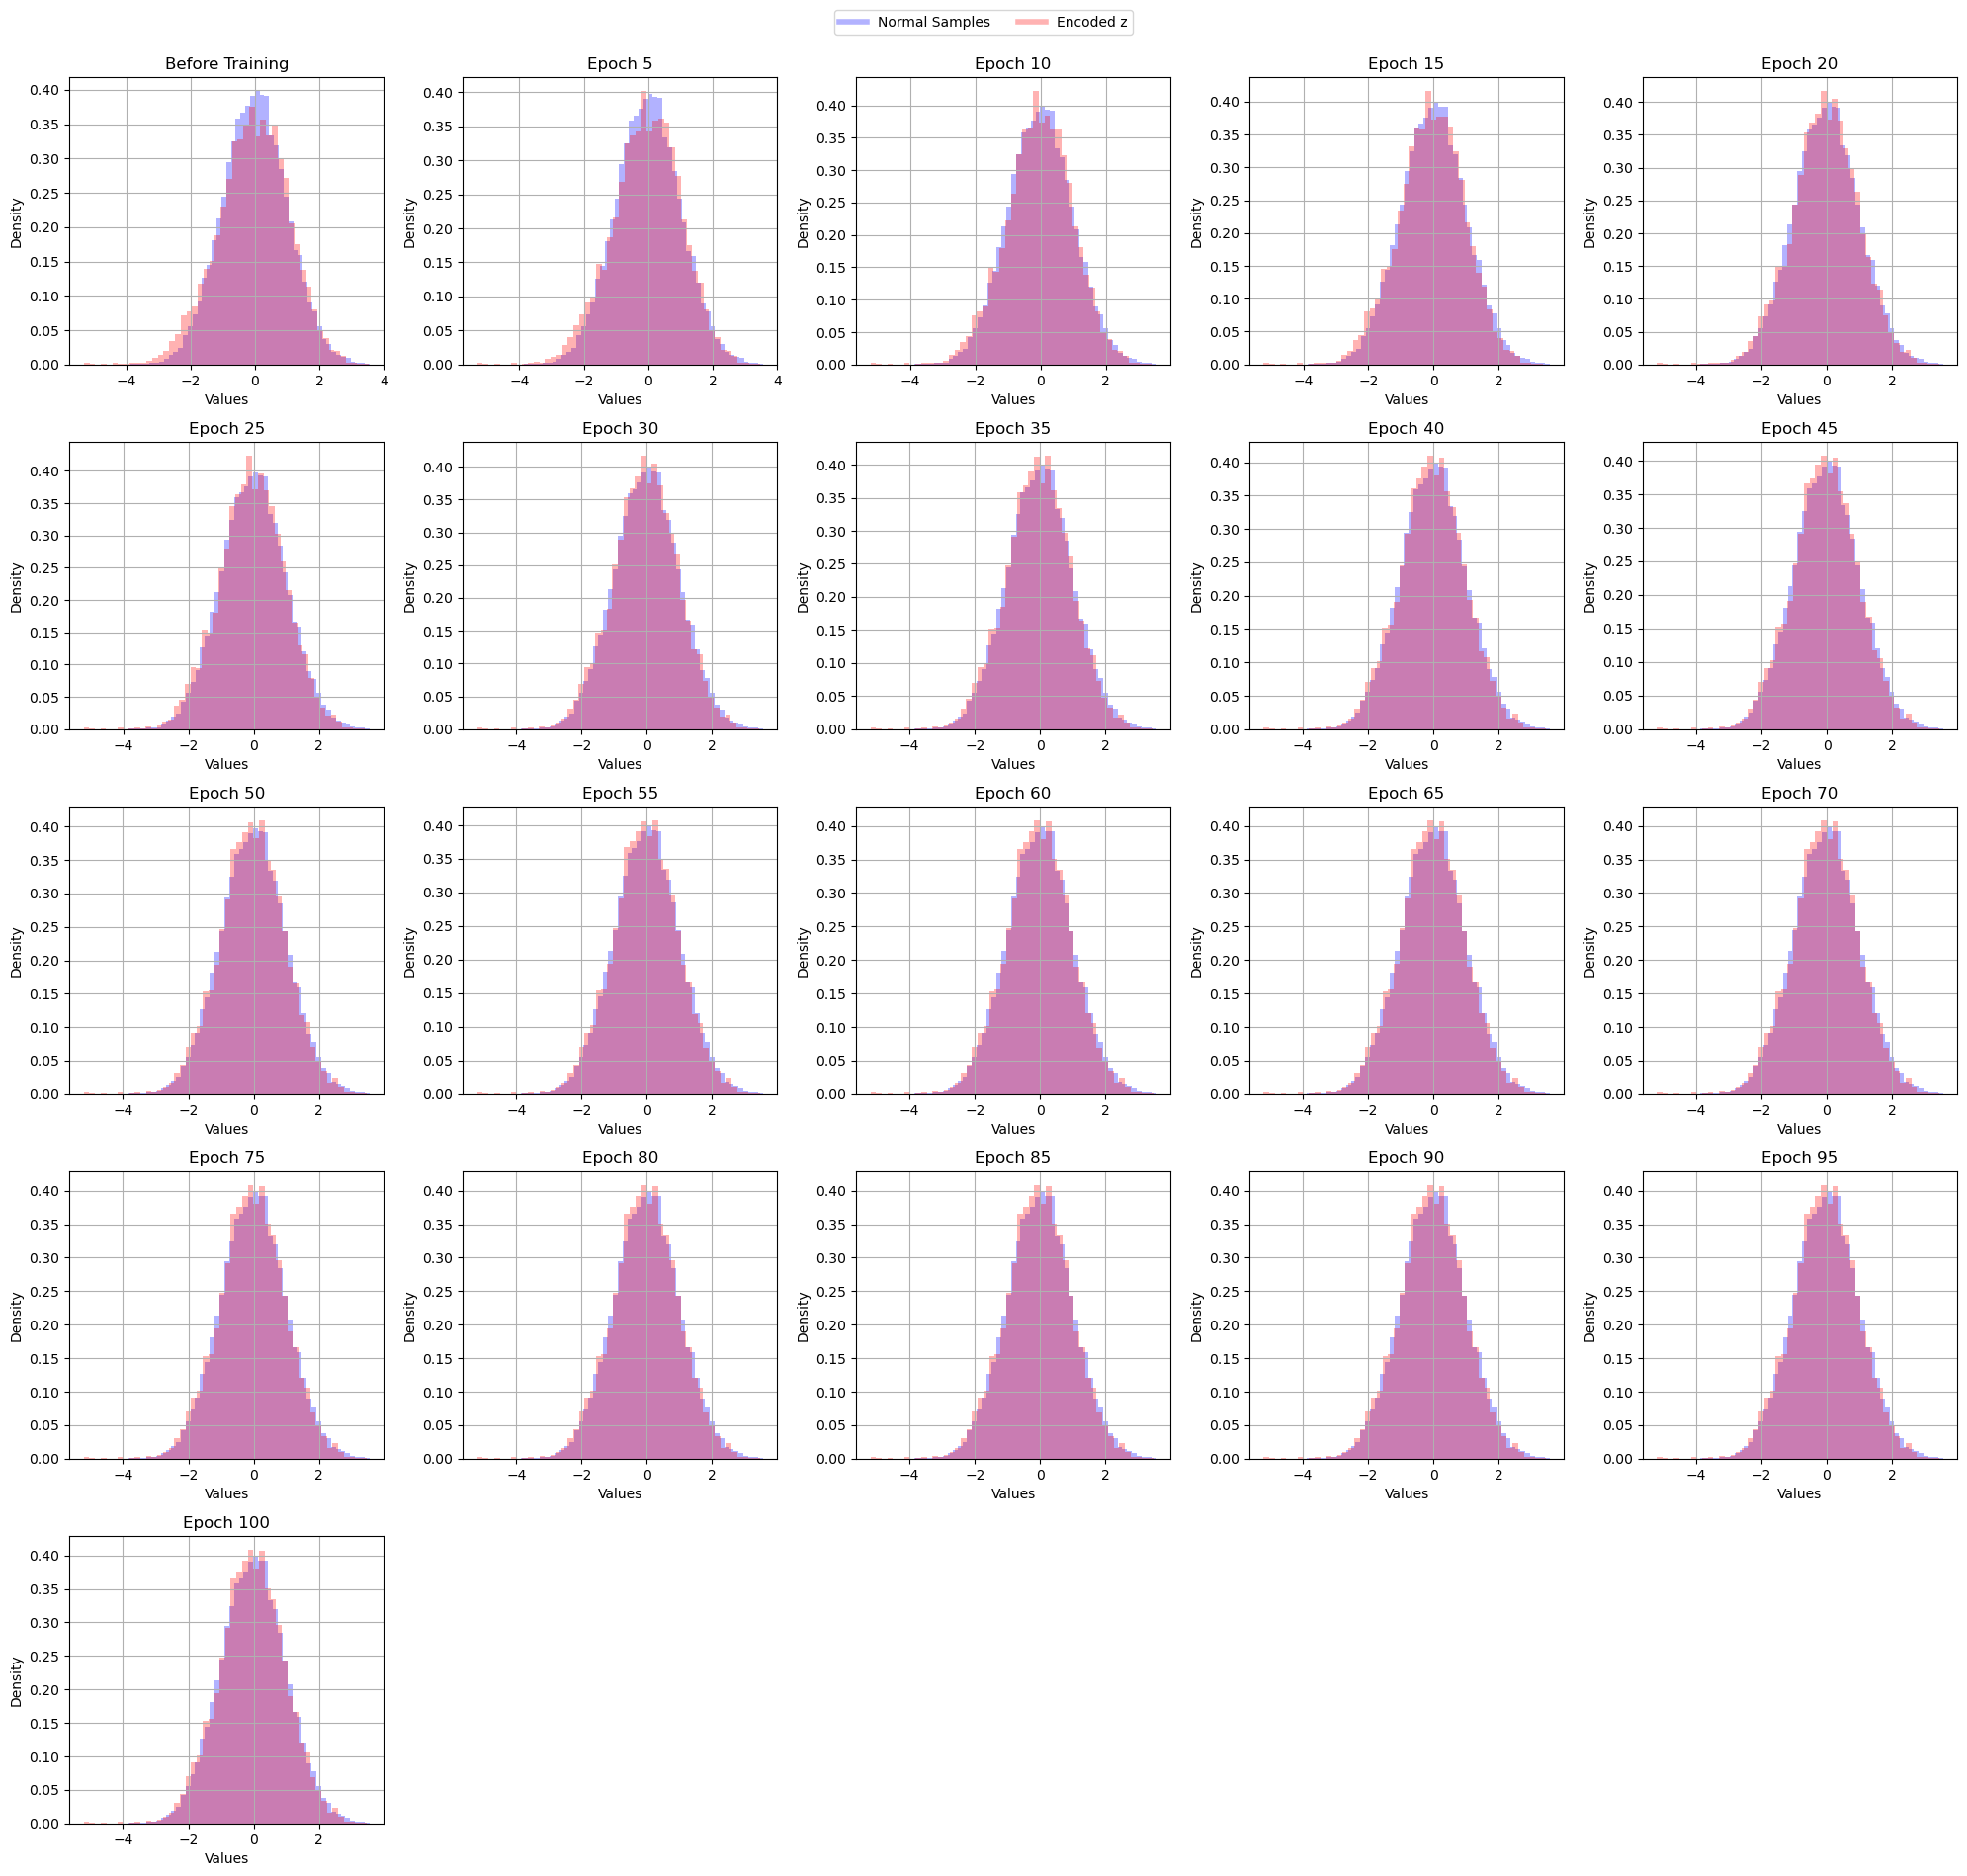

In [19]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=train_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=5)